# 2.7 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링)

- 아주 specific한 에이전트를 개발하는 경우 유리합니다 
- 답변을 생성할 때 다양한 정보가 필요하다면 병렬 처리를 통해 시간을 절약할 수 있습니다

여기서는 세법 계산을 위해 병렬 처리를 위한 케이스를 예로 든다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

먼저 State를 정의

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 세율
    tax_base_equation: str # 과세표준 계산 수식 
    tax_deduction: str # 공제액 
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산
    
graph_builder = StateGraph(AgentState)

In [3]:
import os 

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

공용 프롬프트와 llm 정의

In [5]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(
    model='gpt-4o',
)

**(중요)** 수식을 가져오는 chain 정의

In [6]:
tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()} # 이렇게 하면 invoke시 딕셔너리 형태로 넘어감(invoke("xxx") 이렇게 사용 가능능)
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

한번에 수식 추출하면 LLM이 실수를 할수 있기 때문에, 방법 찾기 -> 수식 추출 과정을 거치도록 chain을 하나더 만든다.

In [7]:

tax_base_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

함수 정의

In [8]:
def get_tax_base_equation(state: AgentState) -> AgentState:
    """
    종합부동산세 과세표준을 계산하는 수식을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.

    Args:
        state (AgentState): 현재 에이전트의 상태를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_base_equation' 키를 포함하는 새로운 `state`를 반환합니다.
    """
    # 과세표준을 계산하는 방법을 묻는 질문을 정의합니다.
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    
    # tax_base_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question) # 딕셔너리로 입력 필요 없음
    
    # state에서 'tax_base_equation' 키에 대한 값을 반환합니다.
    return {'tax_base_equation': tax_base_equation}

테스트 해보기

In [9]:
get_tax_base_equation({}) # 아무 것도 입력하지 않아도 됨

{'tax_base_equation': '과세표준 = 과세대상 자산의 공시가격 - 공제금액 - 감면금액'}

비슷한 방식으로 공제액을 조회하는 chain과 함수 정의

In [10]:

tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> AgentState:
    """
    종합부동산세 공제금액에 관한 정보를 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_deduction' 키를 포함하는 새로운 state를 반환합니다.
    """
    # 공제금액을 묻는 질문을 정의합니다.
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    
    # tax_deduction_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    
    # state에서 'tax_deduction' 키에 대한 값을 반환합니다.
    return {'tax_deduction': tax_deduction}

테스트

In [11]:
get_tax_deduction({})

{'tax_deduction': '죄송하지만, 주택에 대한 종합부동산세 계산 시의 공제금액에 대한 정보가 제공된 문맥에서는 찾을 수 없습니다. 관련 정보를 확인하시려면 국세청 또는 관련 공식 자료를 참고하시기 바랍니다.'}

- 잘안됨. 다시 해볼 것

웹검색 기능(예를 들어 대통령령 검색을 위해)

In [12]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState) -> AgentState:
    """
    web 검색을 통해 주택 공시가격에 대한 공정시장가액비율을 가져옵니다.
    `node`로 활용되기 때문에 `state`를 인자로 받지만, 
    고정된 기능을 수행하기 때문에 `state`를 활용하지는 않습니다.
    
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'market_ratio' 키를 포함하는 새로운 state를 반환합니다.
    """
    # 오늘 날짜에 해당하는 공정시장가액비율을 묻는 쿼리를 정의합니다.
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    
    # tavily_search_tool을 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = tavily_search_tool.invoke(query)
    
    # tax_market_ratio_chain을 구성하여 쿼리와 컨텍스트를 처리합니다.
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_market_ratio_chain을 사용하여 시장 비율을 계산합니다.
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    
    # state에서 'market_ratio' 키에 대한 값을 반환합니다.
    return {'market_ratio': market_ratio}

테스트

In [13]:
get_market_ratio({})

{'market_ratio': '2025년에는 1주택자를 대상으로 한 공정시장가액비율 특례가 계속 적용됩니다. 이에 따라 주택 공시가격에 따른 공정시장가액비율은 다음과 같습니다:\n\n- 공시가격 3억 원 이하: 43%\n- 공시가격 3억 원 초과 ~ 6억 원 이하: 44%\n- 공시가격 6억 원 초과: 45%'}

위 결과를 기반으로 과세 표준을 계산하는 노드

In [14]:
tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state: AgentState) -> AgentState:
    """
    주어진 state에서 과세표준을 계산합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'tax_base' 키를 포함하는 새로운 state를 반환합니다.
    """
    # state에서 필요한 정보를 추출합니다.
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    
    # tax_base_calculation_chain을 구성하여 과세표준을 계산합니다.
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_base_calculation_chain을 사용하여 과세표준을 계산합니다.
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })

    # state에서 'tax_base' 키에 대한 값을 반환합니다.
    return {'tax_base': tax_base}

테스트 

In [15]:
initial_state = {
    "query": query,
    "tax_base_equation": "과세표준 = (과세대상 금액 - 공제금액) x 공정시장가액비율",
    "tax_deduction": "주택에 대한 종합부동산세 계산 시 공제 금액은 1세대 1주택자의 경우 12억원",
    "market_ratio": "2024년 주택 공시가격의 공정시장가액 비율은 60%",
}

calculate_tax_base(initial_state)

{'tax_base': '사용자가 보유한 주택의 총 공시가격을 계산해보면 다음과 같습니다:\n\n5억 원 + 10억 원 + 20억 원 = 35억 원\n\n1세대 1주택자가 아니므로 공제 금액이 적용되지 않습니다. 따라서 공제금액은 0원입니다.\n\n과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (과세대상 금액 - 공제금액) x 공정시장가액비율\n과세표준 = (35억 원 - 0원) x 60%\n과세표준 = 35억 원 x 0.6\n과세표준 = 21억 원\n\n따라서 과세표준은 21억 원입니다. 이 과세표준을 바탕으로 세율에 따라 종합부동산세를 계산하게 됩니다. 세율은 과세표준과 주택 수에 따라 다르므로, 세율 정보를 추가로 확인해야 정확한 세금 금액을 계산할 수 있습니다.'}

마지막으로 세율을 계산하는 노드

In [16]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    """
    주어진 state에서 세율을 계산합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        dict: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    # state에서 필요한 정보를 추출합니다.
    query = state['query']
    tax_base = state['tax_base']
    
    # retriever를 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = retriever.invoke(query)
    
    # tax_rate_chain을 구성하여 세율을 계산합니다.
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율을 계산합니다.
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })

    # state에서 'answer' 키에 대한 값을 반환합니다.
    return {'answer': tax_rate}

### 그래프만들기

- `node`를 추가하고 `edge`로 연결합니다
- 하나의 `node`에서 `edge`를 활영해서 다양한 `node`들을 연결하면 병렬로 작업이 가능합니다

In [17]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [19]:
graph = graph_builder.compile()

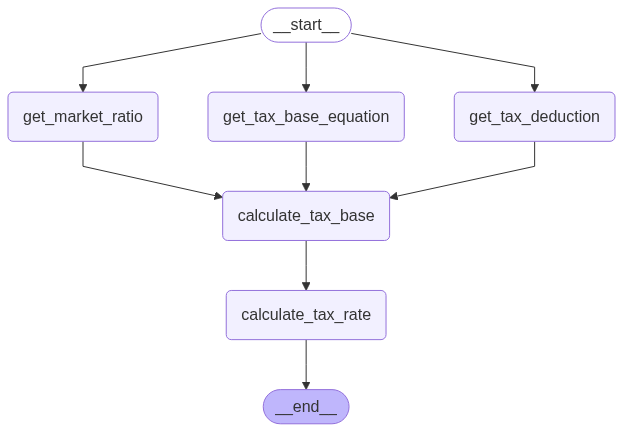

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '종합부동산세를 계산하기 위해서는 주택 수에 따른 공제금액과 과세표준에 따른 세율 정보가 필요합니다. 사용자가 5억, 10억, 20억 원짜리 집 각각 1채씩 총 3채를 소유하고 있다고 가정하겠습니다.\n\n**과세표준 계산:**\n- 5억 원짜리 집: \\((5억 원 - 공제금액) \\times 44%\\)\n- 10억 원짜리 집: \\((10억 원 - 공제금액) \\times 45%\\)\n- 20억 원짜리 집: \\((20억 원 - 공제금액) \\times 45%\\)\n\n**총 과세표준 합산:**\n- \\((5억 원 - 공제금액) \\times 44\\% + (10억 원 - 공제금액) \\times 45\\% + (20억 원 - 공제금액) \\times 45\\%\\)\n\n**주택 수에 따른 공제금액:**\n주택 수가 3채인 경우, 공제금액은 6억 원입니다. 따라서 각 주택의 공제금액을 동일하게 6억 원으로 가정하고 계산합니다.\n\n1. 5억 원짜리 집: 과세표준 = \\( (5억 원 - 6억 원) \\times 44\\% = 0\\) (음수이므로 과세표준 0)\n2. 10억 원짜리 집: 과세표준 = \\( (10억 원 - 6억 원) \\times 45\\% = 4억 원 \\times 45\\% = 1.8억 원\\)\n3. 20억 원짜리 집: 과세표준 = \\( (20억 원 - 6억 원) \\times 45\\% = 14억 원 \\times 45\\% = 6.3억 원\\)\n\n**총 과세표준:**\n- 0 + 1.8억 원 + 6.3억 원 = 8.1억 원\n\n**세율 적용:**\n과세표준에 따른 종합부동산세율은 누진세율로 적용됩니다. 2023년 기준, 주택에 대한 종합부동산세율은 대략적으로 다음과 같습니다 (정확한 세율은 해당 연도의 세법에 따라 다를 수 있습니다):\n\n- 과세표준 6억 원 초과 ~ 